# Optimizing a TF (VGG16) model using SageMaker Neo

SageMaker NEO (https://aws.amazon.com/sagemaker/neo/) is a feature of SageMaker that you can use to optimize a trained model for best performance. It's an OpenSource project based on TVM and Treelite.

https://github.com/neo-ai

It combines a set of optmiziation techniques to reduce the model size, merging operators, etc.

In order to use SageMaker Neo you take a look at this page: https://docs.aws.amazon.com/sagemaker/latest/dg/neo-troubleshooting.html. See the supported operators and then you can build your model following these orientations. After that you can use HyperParameter optimization and other strategies to train your model. So, you can then create a Compilation Job to optimize the trained model yet more.

The assests generated by SageMaker Neo is an intermediate model. It means that you don't need the original framework (used to create your model) anymore. Now you need to use DLR (https://github.com/neo-ai/neo-ai-dlr). A light runtime that will interpret the optimized model in the target device (CPU or GPU). Just install DLR into your device and do predictions!

##### In this exercise we'll create a VGG16 for image classification using Tensorflow. In the part2 we'll optimize it for CPU using SageMake NEO.

### 0) Remember that I told you in the introduction that there is a list of supported Operators?
Ok. So, the function bellow is a helper function that scans the neo-troubleshooting.html page and list the supported operators. That way, you can compare with your model to see if you'll have some issue while trying to optimize your model! Cool, isn't it? :)

In [1]:
import urllib3
import json
from lxml import etree
urllib3.disable_warnings()

In [2]:
# 1) MXNet, 2) TensorFlow, 3) PyTorch/ONNX
def get_operators(framework_id):
    url='https://docs.aws.amazon.com/sagemaker/latest/dg/neo-troubleshooting.partial.html'
    http = urllib3.PoolManager()
    headers={
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.12; rv:61.0) Gecko/20100101 Firefox/61.0'
    }
    req = http.request('GET', url, headers )

    if req.status != 200:
        return None
    html = response = req.data.decode('utf-8')
    root = etree.HTML(html)
    return list(map(lambda x: x.replace("'","").strip(), root.xpath('//div/div/table/tr/td[2]/code/text()')))

In [3]:
TF_SUPPORTED_OPS = get_operators(2)
print(TF_SUPPORTED_OPS)

['Add', 'ArgMax', 'ArgMin', 'AvgPool', 'BatchNormWithGlobalNormalization', 'BiasAdd', 'Cast', 'Ceil', 'CheckNumerics', 'Concat', 'ConcatV2', 'Conv2D', 'DecodeJpeg', 'DepthwiseConv2dNative', 'Elu', 'Equal', 'ExpandDims', 'Fill', 'Floor', 'FusedBatchNorm', 'FusedBatchNormV2', 'GatherV2', 'Greater', 'GreaterEqual', 'Identity', 'LeakyRelu', 'Less', 'LessEqual', 'LRN', 'MatMul', 'Maximum', 'MaxPool', 'Mean', 'Minimum', 'Mul', 'NotEqual', 'Pack', 'Pad', 'PadV2', 'Range', 'Rank', 'Relu', 'Relu6', 'Reshape', 'ResizeBilinear', 'Rsqrt', 'Selu', 'Shape', 'Sigmoid', 'Softmax', 'Square', 'Squeeze', 'StridedSlice', 'Sub', 'Sum', 'Tanh', 'Transpose']


## 1) Dataset Preparation

Let's start by downloading the Caltech256 Dataset and preparing it for training. Then, we need to upload the resulting Dataset to S3.

This preparation consists in:
- transforming all the images into numpy arrays;
- resizing all the images to the CNN input size (3,244,244)
- subtracting the VGG16 mean from all pixels

In [4]:
import os
# Download the dataset if needed
if not os.path.isfile('256_ObjectCategories.tar'):
    !curl -O http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar
    !tar -xf 256_ObjectCategories.tar

In [5]:
import cv2
import numpy as np

# This method loads each image, resizes it, subtracts the VGG mean
def process_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img.astype(np.float32), (224, 224)) #resize
    img -= [123.68, 116.779, 103.939] #subtract image mean
    return img

### 1.2) Here we'll load the references to the images/labels into memory and split it into train/test dataset

In [6]:
import glob
import random
import pandas as pd
from sklearn.model_selection import train_test_split

labels = {}
counter = 0
all_image_paths = list(glob.glob('256_ObjectCategories/*/*.jpg'))
random.shuffle(all_image_paths)

x = []
y = []
for i in all_image_paths:
    _,cat,fname = i.split('/')
    cat_id, cat_name = cat.split('.')
    cat_id = int(cat_id)-1
    labels[cat_id] = cat_name
    x.append(i)
    y.append(cat_id)

stats = np.unique(y, return_counts=True)
minimum = min(stats[1])

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_dist(stats):
    colors=[np.random.rand(3,) for i in range(len(stats[1]))]
    plt.figure(figsize=(20,10))
    plt.bar(stats[0], stats[1], align='center', alpha=0.5, color=colors)
    plt.ylabel('Count')
    plt.title('Dataset distribution')
    plt.show()

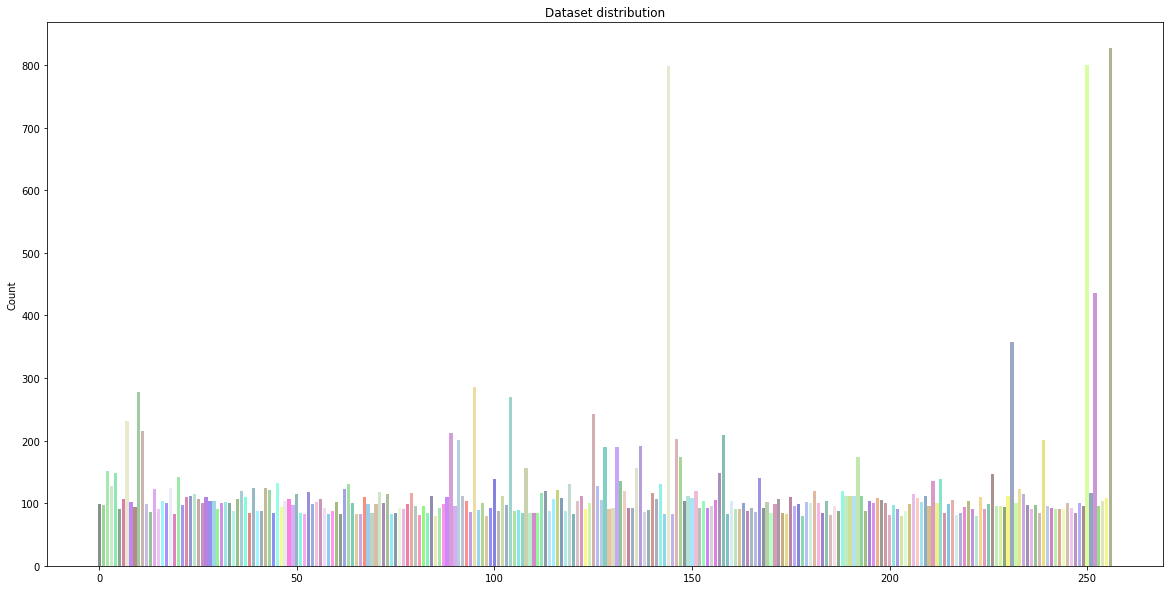

In [8]:
plot_dist( np.unique(y, return_counts=True) )

## 1.3) Ok, the dataset is imbalanced, so, lets undersample it

In [9]:
x__,y__=[],[]
counter = [0]*len(y)
for x_, y_ in zip(x, y):
    if counter[y_] < minimum:
        x__.append(x_)
        y__.append(y_)
        counter[y_] += 1
x = x__
y = y__

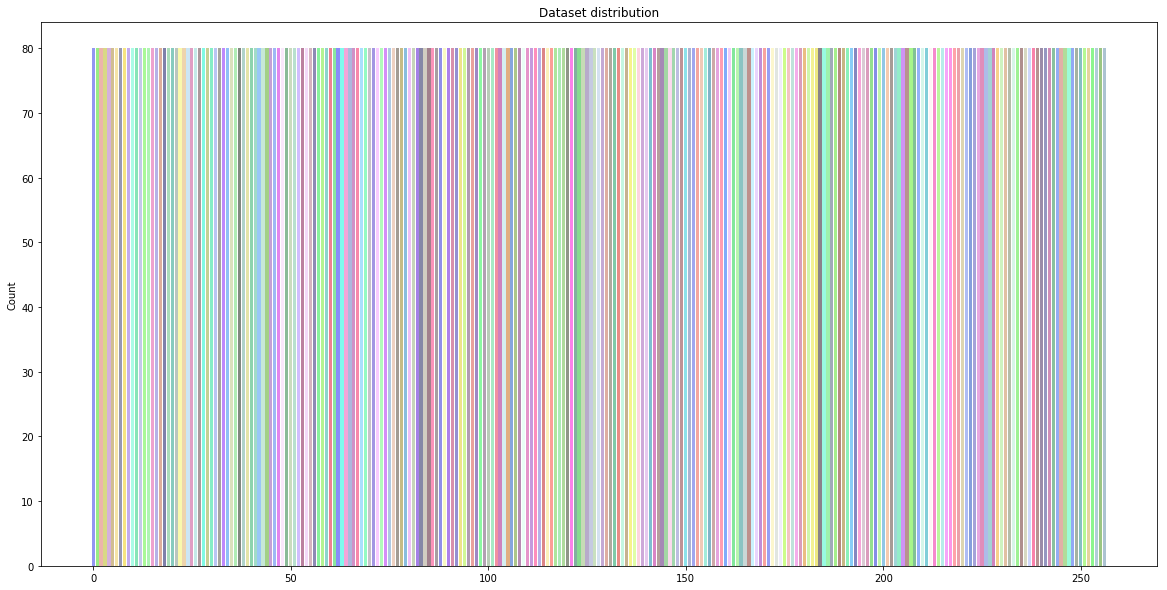

In [10]:
plot_dist( np.unique(y, return_counts=True) )

In [11]:
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.33, random_state=42)

### 1.4) A Sample of the dataset

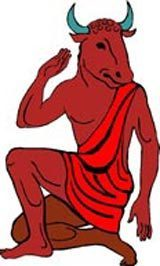

Class id: 143 - minotaur


In [12]:
import random
import IPython.display as display

index = random.randint(0, len(x_train))
image_path = x_train[index]
class_id = y_train[index]
display.display(display.Image(image_path, width=224, height=224))
print("Class id: {} - {}".format( class_id, labels[class_id] ) )

### 1.5) Now, let's convert and save the dataset to the desired numpy format

In [13]:
%%time

# it takes around 7mins

!rm -rf dataset && mkdir -p dataset/train dataset/test dataset/sample/train dataset/sample/test
print('Processing train images')
x_train_processed = list(map(lambda x: process_image(x), x_train))
print('Saving train images')
np.save('dataset/train/x_train.npy', np.array(x_train_processed))
print('Processing test images')
x_test_processed = list(map(lambda x: process_image(x), x_test))
print('Saving test images')
np.save('dataset/test/x_test.npy', np.array(x_test_processed))

print('Saving labels...')
np.save('dataset/train/y_train.npy', np.array(y_train))
np.save('dataset/test/y_test.npy', np.array(y_test))

print('Saving Sample...')
np.save('dataset/sample/train/x_train.npy', np.array(x_train_processed[0:100]))
np.save('dataset/sample/train/y_train.npy', np.array(y_train[0:100]))
np.save('dataset/sample/test/x_test.npy', np.array(x_test_processed[0:100]))
np.save('dataset/sample/test/y_test.npy', np.array(y_test[0:100]))
print('Done')

Processing train images
Saving train images
Processing test images
Saving test images
Saving labels...
Saving Sample...
Done
CPU times: user 4min 13s, sys: 21.3 s, total: 4min 34s
Wall time: 3min 40s


### 1.6) Finally, let's  upload it to S3

In [15]:
%%time
import sagemaker
sagemaker_session = sagemaker.Session()
## aprox 2:50mins
bucket = sagemaker_session.default_bucket()
prefix = 'caltech256'

role = sagemaker.get_execution_role()
print('Copying %s to %s' % ('dataset', prefix))
inputs = sagemaker_session.upload_data(path='dataset', bucket=bucket, key_prefix=prefix)
print('input spec (in this case, just an S3 path): {}'.format(inputs))

Copying dataset to caltech256
input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-715445047862/caltech256
CPU times: user 2min 55s, sys: 2min 3s, total: 4min 58s
Wall time: 2min 1s


## 3) Now, we need to create a SageMaker entrypoint script

This script will be used by SageMaker in order to execute training and serving operations

## 3.1) This script will also contain the model - VGG16 using the low level API of TF

![VGG16 Architecture](vgg16.png)

 - **The input size is:** 224x224x3
 - **You need to subtract the mean of each image before using it:** 123.68, 116.779, 103.939
 - **Keep the image pixels representation in the format:** [0-255]
 - **The first two dense layers have 4096 neurons each. The last one (output) has the number of classes**


In [13]:
%%writefile caltech256_vgg16.py
import argparse
import tensorflow as tf
import numpy as np
import os
import time

from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants

#from vgg16 import VGG16

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Unfortunately, if you are planning to compile and deploy this model with SageMaker NEO
## You need to put everything in just one file, otherwise it will not work
class VGG16(object):
    """VGG16 model"""
    def __init__(self, params):
        self.num_classes = params['num_classes'] if params.get('num_classes') else 1
        batch_size = params['batch_size'] if params.get('batch_size') else 1
        learning_rate = params['learning_rate'] if params.get('learning_rate') else 0.0001
        
        self.x_input = tf.placeholder(tf.float32, [None, 224, 224, 3])
        self.y_input = tf.placeholder(tf.int32, [None])

        def train_preprocess(image, label):
            image = tf.image.random_flip_left_right(image)
            return image, label
        
        dataset = tf.data.Dataset.from_tensor_slices((self.x_input, self.y_input))
        dataset = dataset.map(train_preprocess, num_parallel_calls=4)
        dataset = dataset.batch(batch_size)

        self.iterator = dataset.make_initializable_iterator()

        self.x, self.y = self.iterator.get_next()
        self.y = tf.cast(self.y, tf.int32)
        self.build_model()

        # Define model's cost and optimizer
        self.cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(
                logits=self.logits, 
                labels=tf.one_hot(self.y, depth=self.num_classes)
            )
        )
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)

        # Defining evaluation metrics
        correct_prediction = tf.argmax(self.logits, 1, output_type = tf.int32)
        self.accuracy = tf.reduce_sum(tf.cast(tf.equal(correct_prediction, self.y), tf.float32))
    
    
    def build_model(self):
        # conv 1
        conv1_1 = tf.layers.conv2d(
            self.x, filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, padding='SAME', name='conv1_1'
        )

        conv1_2 = tf.layers.conv2d(
            conv1_1, filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, padding='SAME', name='conv1_2'
        )
        pool1 = tf.layers.max_pooling2d(conv1_2, pool_size=(2, 2), strides=(2, 2), padding='SAME', name='pool1')

        # conv2
        conv2_1 = tf.layers.conv2d(
            pool1, filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, padding='SAME', name='conv2_1'
        )
        conv2_2 = tf.layers.conv2d(
            conv2_1, filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, padding='SAME', name='conv2_2'
        )
        pool2 = tf.layers.max_pooling2d(conv2_2, pool_size=(2, 2), strides=(2, 2), padding='SAME', name='pool2')

        # conv3
        conv3_1 = tf.layers.conv2d(
            pool2, filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, padding='SAME', name='conv3_1'
        )
        conv3_2 = tf.layers.conv2d(
            conv3_1, filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, padding='SAME', name='conv3_2'
        )
        conv3_3 = tf.layers.conv2d(
            conv3_2, filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, padding='SAME', name='conv3_3'
        )
        pool3 = tf.layers.max_pooling2d(conv3_3, pool_size=(2, 2), strides=(2, 2), padding='SAME', name='pool3')

        # conv4
        conv4_1 = tf.layers.conv2d(
            pool3, filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, padding='SAME', name='conv4_1'
        )
        conv4_2 = tf.layers.conv2d(
            conv4_1, filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, padding='SAME', name='conv4_2'
        )
        conv4_3 = tf.layers.conv2d(
            conv4_2, filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, padding='SAME', name='conv4_3'
        )
        pool4 = tf.layers.max_pooling2d(conv4_3, pool_size=(2, 2), strides=(2, 2), padding='SAME', name='pool4')

        # conv5
        conv5_1 = tf.layers.conv2d(
            pool4, filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, padding='SAME', name='conv5_1'
        )
        conv5_2 = tf.layers.conv2d(
            conv5_1, filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, padding='SAME', name='conv5_2'
        )
        conv5_3 = tf.layers.conv2d(
            conv5_2, filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, padding='SAME', name='conv5_3'
        )
        pool5 = tf.layers.max_pooling2d(conv5_3, pool_size=(2, 2), strides=(2, 2), padding='SAME', name='pool5')

        # WARNING: A better approach here is to use tf.layers.flatten, but remember that you
        # can only use supported operators by the optmizer and flatten is not one of them (5 Sept 2019)
        # So, let's do a python operation instead

        # flatten = tf.layers.flatten(pool5, name='flatten')
        flatten = tf.reshape(pool5, [-1, 7*7*512])
        
        fc1_relu = tf.layers.dense(flatten, units=4096, activation=tf.nn.relu, name='fc1_relu')
        dropout1 = tf.layers.dropout(fc1_relu, 0.5, training=True, name='dropout1')
        fc2_relu = tf.layers.dense(dropout1, units=4096, activation=tf.nn.relu, name='fc2_relu')
        dropout2 = tf.layers.dropout(fc2_relu, 0.5, training=True, name='dropout2')
        self.logits = tf.layers.dense(dropout2, units=self.num_classes, name='fc3_relu')
        self.output = tf.nn.softmax(self.logits, name='Softmax')


# Get a TF graph and freeze it
def freeze_graph(sess, path, output_node_names):
    # We use a built-in TF helper to export variables to constants
    output_graph_def = tf.graph_util.convert_variables_to_constants(
        sess, # The session is used to retrieve the weights
        sess.graph_def, # The graph_def is used to retrieve the nodes 
        output_node_names.split(",") # The output node names are used to select the usefull nodes
    )
    
    previous_name = None
    # remove invalid nodes (iterators, dropout, etc)
    for o in list(output_graph_def.node):
        if o.op in ['IteratorV2', 'IteratorGetNext']:
            output_graph_def.node.remove(o)
        elif "dropout" in o.name:
            previous_name = o.input[0] if len(o.input) > 0 and "dropout" not in o.input[0] else previous_name
            output_graph_def.node.remove(o)
        elif previous_name is not None and len(o.input) > 0 and "dropout" in o.input[0]:
            o.input[0] = previous_name
            previous_name = None
            
    # OK this is the final graph, now let's import it to
    # a new fresh graph and remove the iterator (replace it by a placeholder)

    G = tf.Graph()
    # We start a session using a temporary fresh Graph
    with tf.Session(graph = G) as new_sess:
        ## WARNING. Do not use wildcard in the placeholder, 
        ## otherwise the model will crash the DLR
        x_input = tf.placeholder(tf.float32, [1, 224, 224, 3])
        
        tf.import_graph_def(output_graph_def, name="", input_map={"IteratorGetNext": x_input})
        
        print("\n".join(["%s[%s]" % (o.name, o.type) for o in G.get_operations()]))
        # Finally we serialize and dump the output graph to the filesystem
        
        # Note: This directory structure will need to be followed - see notes for the next section
        model_version = '1'
        export_dir = os.path.join(path, 'export', 'Servo', model_version)
        
        # Create prediction signature to be used by TensorFlow Serving Predict API
        
        y_output = G.get_tensor_by_name('Softmax:0')
        signature = predict_signature_def(
            inputs={"inputs": x_input}, outputs={"score": y_output})
        
        # Build the Protocol Buffer SavedModel at 'export_dir'
        bdr = builder.SavedModelBuilder(export_dir)
        bdr.add_meta_graph_and_variables(
            sess=new_sess, tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
        bdr.save()

        if not os.path.isdir(path): os.mkdir(path)
        output_graph = os.path.join(path, 'frozen_model.pb')
        with tf.gfile.GFile(output_graph, "wb") as f:
            f.write(new_sess.graph_def.SerializeToString())

        print("%d ops in the final graph." % len(output_graph_def.node))

def model_fn(model_dir):
    # loading
    model_version = '1'
    export_dir = os.path.join(model_dir, 'export', 'Servo', model_version)
    with tf.Session(graph=tf.Graph()) as sess:
        tf.saved_model.loader.load(sess, [tag_constants.SERVING], export_dir)
        graph = tf.get_default_graph()
        return graph

def predict_fn(payload, model):
    with tf.Session(graph=model) as sess:
        x = model.get_tensor_by_name('Placeholder:0')
        y = model.get_tensor_by_name('Softmax:0')
        return sess.run(y, feed_dict={x: payload})

def get_train_data(train_dir):
    x_train = np.load(os.path.join(train_dir, 'x_train.npy'))
    y_train = np.load(os.path.join(train_dir, 'y_train.npy'))
    return (x_train, y_train)

def get_test_data(test_dir):
    x_test = np.load(os.path.join(test_dir, 'x_test.npy'))
    y_test = np.load(os.path.join(test_dir, 'y_test.npy'))
    return (x_test, y_test)

def train(train_ds, test_ds, args):
    tf.reset_default_graph()
    
    params = {
        'num_classes': args.num_classes,
        'learning_rate': args.learning_rate,
        'batch_size': args.batch_size
    }

    model = VGG16(params)

    x_train,y_train = train_ds
    x_test,y_test = test_ds
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        print("Training for: {} epochs - Batch size: {}".format( args.epochs, args.batch_size) )
        
        for epoch_no in range(args.epochs):
            start_time = time.time()
            train_loss, train_accuracy = 0, 0
            val_loss, val_accuracy = 0, 0

            # Initialize iterator with training data
            sess.run(model.iterator.initializer, feed_dict = {model.x_input: x_train, model.y_input: y_train})
            try:
                while True:
                    _, loss, acc = sess.run([model.optimizer, model.cost, model.accuracy])
                    train_loss += loss 
                    train_accuracy += acc
            except tf.errors.OutOfRangeError:
                pass
            
            # Initialize iterator with training data
            sess.run(model.iterator.initializer, feed_dict = {model.x_input: x_test, model.y_input: y_test})
            try:
                while True:
                    loss, acc = sess.run([model.cost, model.accuracy])
                    val_loss += loss 
                    val_accuracy += acc
            except tf.errors.OutOfRangeError:
                pass
            
            print('\nEpoch No: {}'.format(epoch_no + 1))
            print('train_acc={:.4f}; train_loss={:.4f};'.format(train_accuracy / len(y_train), 
                                                            train_loss / len(y_train)))
            print('val_acc={:.4f}; val_loss={:.4f};'.format(val_accuracy / len(y_test), 
                                                            val_loss / len(y_test)))
            print('Elapsed time={:.2f}mins'.format( (time.time() - start_time ) / 60.0 ) )
            # Save checkpoint
            saver.save(sess, os.path.join(args.intermediate_dir, 'model'))
        freeze_graph( sess, args.model_dir, 'Softmax')


def neo_preprocess(payload, content_type):
    import logging
    import numpy as np
    import io

    logging.info('Invoking user-defined pre-processing function')

    if content_type != 'application/x-image' and content_type != 'application/vnd+python.numpy+binary':
        raise RuntimeError('Content type must be application/x-image or application/vnd+python.numpy+binary')

    image = np.load(io.BytesIO(payload))
    h,w,c = image.shape
    if h != 224 or w != 224:
        raise RuntimeError('You need to resize the image to 224x224 before posting it')
    image -= [123.68, 116.779, 103.939]

    return image

### NOTE: this function cannot use MXNet
def neo_postprocess(result):
    import logging
    import numpy as np
    import json

    logging.info('Invoking user-defined post-processing function')
    
    # Softmax (assumes batch size 1)
    result = np.squeeze(result)
    result_exp = np.exp(result - np.max(result))
    result = result_exp / np.sum(result_exp)

    response_body = json.dumps(result.tolist())
    content_type = 'application/json'

    return response_body, content_type

def parse_args():

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--learning_rate', type=float, default=0.001)
    
    parser.add_argument('--num_classes', type=int, default=10)

    # data directories
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--test', type=str, default=os.environ.get('SM_CHANNEL_TEST'))
    
    parser.add_argument('--intermediate_dir', type=str, default=os.environ.get('SM_OUTPUT_INTERMEDIATE_DIR'))

    # model directory: we will use the default set by SageMaker, /opt/ml/model
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))

    return parser.parse_known_args()

if __name__ == "__main__":

    args, _ = parse_args()

    train_ds = get_train_data(args.train)
    test_ds = get_test_data(args.test)

    train(train_ds, test_ds, args )

Overwriting caltech256_vgg16.py


### 3.2) Test it locally first, with just a sample of the dataset

In [14]:
import os

from importlib import reload
#import sys
#sys.path.insert(0,'src')
import caltech256_vgg16 as c
import numpy as np
c = reload(c)

In [15]:
!rm -rf model intermediate && mkdir -p model intermediate

train_ds = c.get_train_data('dataset/sample/train')
test_ds = c.get_test_data('dataset/sample/test')
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

args = dotdict({
    'epochs': 1,
    'batch_size': 6,
    'num_classes': 257,
    'learning_rate': 0.00001,
    'model_dir': 'model',
    'intermediate_dir': 'intermediate',
    'weights': None
})
c.train(train_ds, test_ds, args)

Training for: 1 epochs - Batch size: 6

Epoch No: 1
train_acc=0.0000; train_loss=0.9569;
val_acc=0.0200; val_loss=0.9566;
Elapsed time=0.23mins
Placeholder[Placeholder]
conv1_1/kernel[Const]
conv1_1/kernel/read[Identity]
conv1_1/bias[Const]
conv1_1/bias/read[Identity]
conv1_1/Conv2D[Conv2D]
conv1_1/BiasAdd[BiasAdd]
conv1_1/Relu[Relu]
conv1_2/kernel[Const]
conv1_2/kernel/read[Identity]
conv1_2/bias[Const]
conv1_2/bias/read[Identity]
conv1_2/Conv2D[Conv2D]
conv1_2/BiasAdd[BiasAdd]
conv1_2/Relu[Relu]
pool1/MaxPool[MaxPool]
conv2_1/kernel[Const]
conv2_1/kernel/read[Identity]
conv2_1/bias[Const]
conv2_1/bias/read[Identity]
conv2_1/Conv2D[Conv2D]
conv2_1/BiasAdd[BiasAdd]
conv2_1/Relu[Relu]
conv2_2/kernel[Const]
conv2_2/kernel/read[Identity]
conv2_2/bias[Const]
conv2_2/bias/read[Identity]
conv2_2/Conv2D[Conv2D]
conv2_2/BiasAdd[BiasAdd]
conv2_2/Relu[Relu]
pool2/MaxPool[MaxPool]
conv3_1/kernel[Const]
conv3_1/kernel/read[Identity]
conv3_1/bias[Const]
conv3_1/bias/read[Identity]
conv3_1/Conv2D[Co

### 3.3) Let's check if our model is compatible with SageMaker NEO 

In [16]:
import tensorflow as tf

model = c.model_fn('model')
ops = model.get_operations()
for o in ops:
    if not o.type in TF_SUPPORTED_OPS:
        if o.type in ['Placeholder', 'Const']:
            # Placeholders and constants are allowed
            continue
        print("WARNING!! YOUR MODEL WILL NOT BE COMPILED BY SAGEMAKER NEO. UNSUPPORTED OPERATOR: {}[{}]".format( 
            o.name, o.type ))
        break

### 3.4) Finaly we'll see how long it take to do a single prediction, locally

In [17]:
%%time
import time
payload = np.expand_dims( process_image(x_train[0]), axis=0 )

start_time = time.time()
out = c.predict_fn(payload, model)
elapsed_time = time.time() - start_time
print("Elapsed time: %0.3f" % elapsed_time)

Elapsed time: 6.904
CPU times: user 3.31 s, sys: 3.56 s, total: 6.86 s
Wall time: 6.91 s


In [18]:
import numpy as np

idx = np.argmax(out[0])
idx, out[0][idx]

(195, 0.0070792194)

### Alright, we're ready to train the model with the whole Dataset. Just go to the second part of this exercise